In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Introduction

In past videos, we’ve discussed and demonstrated:

* Building models with the neural network layers and functions of the torch.nn module
* The mechanics of automated gradient computation, which is central to gradient-based model training
* Using TensorBoard to visualize training progress and other activities

# Dataset and DataLoader
The Dataset and DataLoader classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The Dataset is responsible for accessing and processing single instances of data.

The DataLoader pulls instances of data from the Dataset (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The DataLoader works with all kinds of datasets, regardless of the type of data they contain.

For this tutorial, we’ll be using the Fashion-MNIST dataset provided by TorchVision. We use torchvision.transforms.Normalize() to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.



In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


As always, let’s visualize the data as a sanity check:

Coat  Shirt  Coat  Coat


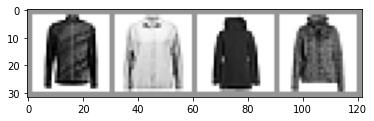

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

# The Model
The model we’ll use in this example is a variant of LeNet-5 - it should be familiar if you’ve watched the previous videos in this series.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()
model

GarmentClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Loss Function
For this example, we’ll be using a cross-entropy loss. For demonstration purposes, we’ll create batches of dummy output and label values, run them through the loss function, and examine the result.

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.8672, 0.9586, 0.4316, 0.0205, 0.4377, 0.1035, 0.6014, 0.1558, 0.9255,
         0.1689],
        [0.2691, 0.2199, 0.6342, 0.0433, 0.4571, 0.5996, 0.8654, 0.7449, 0.5578,
         0.3751],
        [0.5050, 0.2308, 0.0046, 0.1406, 0.7634, 0.1291, 0.5930, 0.9327, 0.6154,
         0.1771],
        [0.6858, 0.1328, 0.9012, 0.0871, 0.7380, 0.1647, 0.6059, 0.9957, 0.2882,
         0.9230]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.1517252922058105


Optimizer
For this example, we’ll be using simple stochastic gradient descent with momentum.

It can be instructive to try some variations on this optimization scheme:

* Learning rate determines the size of the steps the optimizer takes. What does a different learning rate do to the your training results, in terms of accuracy and convergence time?
* Momentum nudges the optimizer in the direction of strongest gradient over multiple steps. What does changing this value do to your results?
* Try some different optimization algorithms, such as averaged SGD, Adagrad, or Adam. How do your results differ?

In [10]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# The Training Loop
Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

* Gets a batch of training data from the DataLoader
* Zeros the optimizer’s gradients
* Performs an inference - that is, gets predictions from the model for an input batch
* Calculates the loss for that set of predictions vs. the labels on the dataset
* Calculates the backward gradients over the learning weights
* Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
* It reports on the loss for every 1000 batches.
* Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [11]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Per-Epoch Activity
There are a couple of things we’ll want to do once per epoch:

* Perform validation by checking our relative loss on a set of data that was not used for training, and report this
* Save a copy of the model
Here, we’ll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [12]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  batch 1000 loss: 1.7992585874944926
  batch 2000 loss: 0.8485545415878296
  batch 3000 loss: 0.7208732691360638
  batch 4000 loss: 0.6436950080944225
  batch 5000 loss: 0.605469992664177
  batch 6000 loss: 0.5838761807768605
  batch 7000 loss: 0.5432864178980235
  batch 8000 loss: 0.5110421218557749
  batch 9000 loss: 0.5109679168255243
  batch 10000 loss: 0.4794137558119837
  batch 11000 loss: 0.4488081749713747
  batch 12000 loss: 0.46633079904923214
  batch 13000 loss: 0.43178314077295366
  batch 14000 loss: 0.4185997192665236
  batch 15000 loss: 0.415590266504616
LOSS train 0.415590266504616 valid 0.43991410732269287
EPOCH 2:
  batch 1000 loss: 0.37883867275499505
  batch 2000 loss: 0.38752289841044696
  batch 3000 loss: 0.39574425809900277
  batch 4000 loss: 0.38238421273522544
  batch 5000 loss: 0.40249258095474216
  batch 6000 loss: 0.3828329219642328
  batch 7000 loss: 0.34573245046829104
  batch 8000 loss: 0.3965220495777321
  batch 9000 loss: 0.3485956456578497
  batch 1000

To load a saved version of the model:

In [15]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))

NameError: name 'PATH' is not defined

Once you’ve loaded the model, it’s ready for whatever you need it for - more training, inference, or analysis.

Note that if your model has constructor parameters that affect model structure, you’ll need to provide them and configure the model identically to the state in which it was saved.